In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array,array_to_img
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, DepthwiseConv2D, LeakyReLU, Add, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from skimage.transform import resize
from PIL import Image, ImageOps

import glob, os, random

In [2]:
base_path = 'Images/Train/'

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

4580


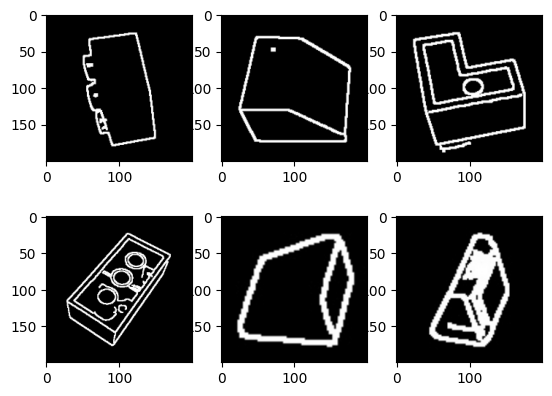

In [3]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    
    img = img_to_array(img, dtype=np.uint8)
    
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True).astype(np.uint8)
    
    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h//2, delta_h-(delta_h//2)), (delta_w//2, delta_w-(delta_w//2)), (0, 0))
    
    img = np.pad(img, padding, 'edge')

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [4]:
def resize_pad(img):
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True)
    
    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h//2, delta_h-(delta_h//2)), (delta_w//2, delta_w-(delta_w//2)), (0, 0))
    
    img = np.pad(img, padding, 'edge')
    
    return img

def preprocessing_train(x):
    x = resize_pad(x)
    return x

def preprocessing_val(x):
    x = resize_pad(x)
    return x

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_train,
    rescale=1./255,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_val,
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    color_mode='grayscale',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    color_mode='grayscale',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 4133 images belonging to 20 classes.
Found 447 images belonging to 20 classes.
{0: 'Brick_1x1', 1: 'Brick_1x2', 2: 'Brick_1x3', 3: 'Brick_1x4', 4: 'Brick_2x2', 5: 'Brick_2x2_L', 6: 'Brick_2x2_Slope', 7: 'Brick_2x3', 8: 'Brick_2x4', 9: 'Plate_1x1', 10: 'Plate_1x1_Round', 11: 'Plate_1x1_Slope', 12: 'Plate_1x2', 13: 'Plate_1x2_Grill', 14: 'Plate_1x3', 15: 'Plate_1x4', 16: 'Plate_2x2', 17: 'Plate_2x2_L', 18: 'Plate_2x3', 19: 'Plate_2x4'}


In [5]:
inputs = Input(shape=(200, 200, 1))

net = Conv2D(filters=64, kernel_size=3, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

shortcut = net

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=64, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=64, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = Add()([shortcut, net])

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=128, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = Flatten()(net)

net = Dense(128, activation='relu')(net)

net = Dense(64, activation='relu')(net)

outputs = Dense(20, activation='softmax')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 200, 200, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [7]:
model.fit_generator(train_generator, epochs=5, validation_data=validation_generator)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27748\428923602.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=5, validation_data=validation_generator)


Epoch 1/5
130/130 [==============================] - 155s 1s/step - loss: 0.2999 - acc: 0.8904 - val_loss: 0.3336 - val_acc: 0.9105
Epoch 2/5
130/130 [==============================] - 158s 1s/step - loss: 0.2723 - acc: 0.9044 - val_loss: 0.3327 - val_acc: 0.9195
Epoch 3/5
130/130 [==============================] - 156s 1s/step - loss: 0.2613 - acc: 0.9095 - val_loss: 0.5125 - val_acc: 0.8277
Epoch 4/5
130/130 [==============================] - 150s 1s/step - loss: 0.2706 - acc: 0.9025 - val_loss: 0.4699 - val_acc: 0.8770
Epoch 5/5
130/130 [==============================] - 134s 1s/step - loss: 0.2546 - acc: 0.9122 - val_loss: 0.3835 - val_acc: 0.8971


In [8]:
model.save_weights('Weights2')
print('Model Saved!')

Model Saved!


In [418]:
savedModel = model.load_weights('Weights')

(921, 1024)
(200, 200, 1)
(1, 200, 200, 1)
1/1 [==============================] - 0s 62ms/step
[[5.8229396e-04 3.9429275e-07 1.5818537e-03 8.3291209e-01 2.4530985e-03
  4.7710454e-04 3.6624895e-04 3.6294091e-02 5.6097549e-03 9.6123642e-04
  1.0559227e-03 8.0253906e-04 7.3630792e-05 1.0846476e-05 4.8934100e-03
  2.0179857e-02 7.2938856e-04 8.3871724e-05 3.2906078e-02 5.8026228e-02]]
Brick_1x4
3


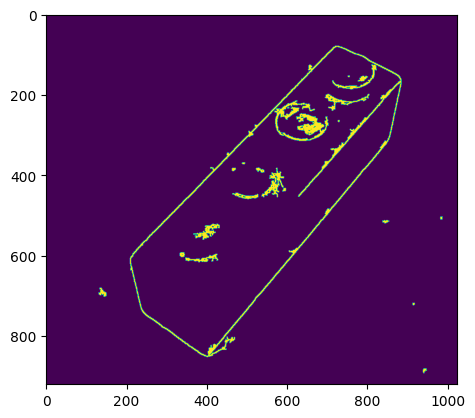

In [430]:
import cv2
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    blurred = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(blurred,10, 200, apertureSize= 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate = cv2.dilate(edged, kernel, iterations=1)
    return (dilate)

test=get_image('test.jpg')
img = img_to_array(test, dtype=np.float32)
print(test.shape)
plt.imshow(test)

test=resize_pad(img)
print(test.shape)
test = test.reshape((1,) + test.shape)
print(test.shape)
test = test_datagen.flow(test, batch_size=32, shuffle=False)

predictions=model.predict(test)
print(predictions)

pred=np.argmax(predictions)
print(labels[pred])
print(pred)